In [1]:
# Custom Imports
from polymer_utils import analysis, general, filetree, molutils
from polymer_utils import simulation as polysim

from polymer_utils import charging
from polymer_utils.charging.types import AtomIDMap, ResidueChargeMap
from polymer_utils.charging.residues import ChargedResidue

from polymer_utils.representation import PolymerDir, PolymerDirManager
from polymer_utils.representation import LOGGER as polylogger
from polymer_utils.solvation.solvents import WATER_TIP3P
from polymer_utils.analysis import trajectory, propplot
from polymer_utils.logutils import config_mlf_handler
from polymer_utils.graphics import rdkdraw

# General Imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL.Image import Image # for typing
from datetime import datetime

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree

# Logging and Shell
from IPython.display import clear_output
import subprocess
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.units import unit
from openff.interchange import Interchange

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openmm.openmm import MonteCarloBarostat
from openff.toolkit.utils.exceptions import ConformerGenerationError
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper

from openmm import LangevinMiddleIntegrator, Context
from openmm.vec3 import Vec3
from openmm.app import Simulation, PDBReporter, StateDataReporter

from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# Static Paths
RESOURCE_PATH = Path('resources')
COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs')

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Configuring and (re)loading polymers, setting solvents, checking validity

In [ ]:
reset      = False
purge_sims = False 
purge_logs = False

poly_source_path = COMPAT_PDB_PATH / 'simple_polymers_updated'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_Colina'
solv_template    = RESOURCE_PATH/'inp_templates'/'solv_polymer_template_box.inp'
desired_solvents = (WATER_TIP3P,) # (None,)
exclusion = 1.0*nanometer

# ------------------------------------------------------------------------------

collection_path  = COLL_PATH / poly_source_path.name
structure_path   = poly_source_path / f'{poly_source_path.name}_structures'
monomer_path     = poly_source_path / f'{poly_source_path.name}_monomers'

mgr = PolymerDirManager(collection_path)

# ------------------------------------------------------------------------------

creation_logger = logging.getLogger('polymer_setup')
loggers = [creation_logger, polylogger] 
creation_log_handler = config_mlf_handler(mgr.log_dir/f'Setup_{general.timestamp_now()}.log', loggers, writemode='a')

if reset:
    mgr.purge_collection(really=True, purge_logs=purge_logs) 

if purge_sims:
    mgr.purge_sims(really=True)

if not mgr.mol_dirs: # will be empty if not yet instantiated or if reset prior
    mgr.populate_collection(struct_dir=structure_path, monomer_dir=monomer_path)
    mgr.solvate_collection(desired_solvents, template_path=solv_template, exclusion=exclusion)
    creation_logger.info(f'Completed creation of collection "{collection_path.name}"')
    
creation_log_handler.remove_from_loggers(*loggers)

In [6]:
# Selecting subset of molecules which is suitable for ABE10 charging and subsequent simulation
HARD_POLYMERS = ['vulcanizedrubber', 'polyphenylenesulfone', 'polyethylene', 'polyphenyleneI'] # pathological or otherwise difficult-to-run polymers that I've encountered
EASY_POLYMERS = ['polyvinylchloride_solv_water', 'polyethylmethacrylate_solv_water'] + ['naturalrubber_solv_water', 'PEO_PLGA_solv_water'] # the quickest-to-charge and -to-simulate polymers in the sample set

MolFilter = Callable[[PolymerDir], bool]
whitelisted  = lambda mol_dir : mol_dir.base_mol_name not in HARD_POLYMERS
matchable    = lambda mol_dir : mol_dir.has_monomer_data
AM1_sized    = lambda mol_dir : 0 < mol_dir.n_atoms <= 300
good_solvent = lambda mol_dir : mol_dir.solvent in desired_solvents

filters : tuple[MolFilter] = (whitelisted, matchable, AM1_sized, good_solvent)
valid_mols = {
    mol_dir.mol_name : mol_dir
        for mol_dir in mgr.mol_dirs_list
            if all(_filter(mol_dir) for _filter in filters)
}

# display to check that loading has gone as planned
# for pdir in sorted(mgr.mol_dirs_list, key = lambda mdir : mdir.n_atoms):
#     print(pdir.mol_name)
# print(mgr.all_completed_sims)
print(valid_mols.keys())

dict_keys(['polyvinylchloride_solv_water', 'atactic_styrene_solv_water', 'syntactic_styrene_solv_water', 'naturalrubber_solv_water', 'polythiophene_solv_water', 'polyethylmethacrylate_solv_water', 'peg_modified_solv_water', 'polyetherketone_solv_water', 'PEO_PLGA_solv_water'])


## Charge and sim loop V2

In [8]:
# DEFINE TARGET MOLECULES AND FORCEFIELD
# sample_mols = valid_mols
sample_mols = EASY_POLYMERS
main_ff_xml = RESOURCE_PATH/'force_fields'/'openff_constrained-2.0.0.offxml'
# main_ff_xml = RESOURCE_PATH/'force_fields'/'openff_unconstrained-2.0.0.offxml'

# CHARGING PARAMETERS
overwrite_ff_xml     = False #True
overwrite_chg_json   = False #True
distrib_mono_charges = True

strict   = True
verbose  = False

avg_charge_method = 'ABE10_exact' # 'Espaloma_AM1BCC'
if avg_charge_method == 'ABE10_averaged':
    raise ValueError('Charge averaging must be performed over a non-averaged (i.e. pure) set of charges')

# SIMULATION PARAMETERS
run_sims = True
sim_param_path = RESOURCE_PATH/'sim_templates'/'debug_sim.json'
# sim_param_path = RESOURCE_PATH/'sim_templates'/'standard_sim.json'
sim_params = polysim.SimulationParameters.from_file(sim_param_path)

# ANALYSIS PARAMETERS
perform_analysis = True
traj_sample_interval = 5 # interval between consecutive time points for trajectory analysis (needed for longer sims)

# PRE-FLIGHT CALCULATIONS
sample_dirs = {
    mol_name : mgr.mol_dirs[mol_name] # TOSELF : deliberately not using .get() so this raises an easier-to-debug KeyError
        for mol_name in sample_mols
}
action_str = f'Charging{" & simulation" if run_sims else ""}'

print(sim_params)
print(sim_params.num_steps, sim_params.record_freq)
print(sample_dirs.keys())

SimulationParameters(total_time=Quantity(value=10, unit=nanosecond), num_samples=2500, charge_method='ABE10_averaged', reported_state_data={'step': True, 'time': True, 'potentialEnergy': True, 'kineticEnergy': True, 'totalEnergy': True, 'temperature': True, 'volume': True, 'density': True, 'progress': False, 'remainingTime': False, 'speed': True, 'elapsedTime': True}, timestep=Quantity(value=2, unit=femtosecond), temperature=Quantity(value=300, unit=kelvin), pressure=Quantity(value=1, unit=atmosphere), friction_coeff=Quantity(value=1, unit=/picosecond), barostat_freq=25)
5000000 2000
dict_keys(['polyvinylchloride_solv_water', 'polyethylmethacrylate_solv_water', 'naturalrubber_solv_water', 'PEO_PLGA_solv_water'])


In [9]:
# BEGIN CHARGING / SIM LOOP - Perform charge averaging on all target molecules which don't already have averaged LCs; Load forcefield for those which already do 
main_logger = logging.getLogger(__name__)
loggers = [main_logger, polylogger] 
main_log_handler = config_mlf_handler(mgr.log_dir/f'{action_str}_{general.timestamp_now()}.log', loggers, writemode='a')

main_logger.info(f'Beginning {action_str} loop...\n')
for i, (mol_name, mol_dir) in enumerate(sample_dirs.items()):
    try:
        # 0) LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
        main_logger.info(f'Current molecule: "{mol_name}" ({i + 1}/{len(sample_dirs)})') # +1 converts to more human-readable 1-index for step count
        polymer_log_handler = config_mlf_handler(mol_dir.logs/f'{general.timestamp_now()}.log', loggers, writemode='w') # NOTE : order matters, initial main logger call above should not record to local polymer log
        if not mol_dir.has_monomer_data:
            raise FileExistsError(f'No monomer JSONs found for {mol_name}')

        # 1) ENSURING AM1-BBC-CHARGED (UNAVERAGED) SDF FILES EXIST - WILL RECHARGE AND REGENERATE IF NONE EXIST
        cmols = {}
        for chg_method in ('Espaloma_AM1BCC', 'ABE10_exact'):
            if all(chg_method in reg_dict for reg_dict in (mol_dir.charges, mol_dir.structure_files_chgd)): # if charges and charge Molecule SDFs already exist for the current method
                main_logger.info(f'(1-precheck) Found existing pure charged molecule for {chg_method}')
                cmol = mol_dir.charged_offmol_from_sdf(chg_method)
            else:
                main_logger.warning(f'(1-needs gen) No existing pure molecule charges found, recharging via {chg_method}')
                chgr = charging.application.CHARGER_REGISTRY[chg_method]()
                cmol, sdf_path = mol_dir.charge_and_save_molecule(chgr, strict=strict, verbose=verbose, chgd_monomers=False, topo_only=True)

            cmols[chg_method] = cmol
        main_logger.info(f'(1) Acquired all pure charged molecules')
        
        # 2) CREATE JSON AND SDF WITH AVERAGED CHARGES IF ONE DOES NOT ALREADY EXIST
        avg_method = charging.application.ABE10AverageCharger.TAG
        if all(avg_method in reg_dict for reg_dict in (mol_dir.charges, mol_dir.structure_files_chgd)): # if charges and charge Molecule SDFs already exist for the current method
            main_logger.info(f'(2-precheck) Found existing monomer-averaged charged molecule')
            cmol_avgd = mol_dir.charged_offmol_from_sdf(avg_method)
        else:
            main_logger.warning('(2.1-needs gen) No existing monomer-averaged molecule charges found, re-averaging')

            main_logger.info(f'Averaging charges over {mol_dir.mol_name} residues')
            cmol = cmols[avg_charge_method]
            avgd_res, atom_id_mapping = charging.averaging.get_averaged_charges(cmol, monomer_data=mol_dir.monomer_data, distrib_mono_charges=distrib_mono_charges)
            residue_charges = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgd_res}
            
            main_logger.info(f'Generating charged SDF for monomer-averaged charges')
            avg_chgr = charging.application.ABE10AverageCharger()
            avg_chgr.set_residue_charges(residue_charges)
            cmol_avgd, sdf_path = mol_dir.charge_and_save_molecule(avg_chgr, strict=strict, verbose=verbose, chgd_monomers=False, topo_only=True)
            main_logger.info(f'Monomer-averaged charging completed')
        
            if (mol_dir.monomer_file_chgd is None) or overwrite_chg_json: # can only reach this branch if a json is present but isn't identified as charged within the PolymerDir
                main_logger.warning('(2.2-needs gen) Generating new charged JSON monomer file')
                mol_dir.create_charged_monomer_file(residue_charges)

        cmols[avg_method] = cmol_avgd
        monomer_data = mol_dir.monomer_data_charged # double check that the charged data is in fact loadable
        main_logger.info('(2) Acquired charge-averaged monomer JSON')

        # 3) CREATE FORCE FIELD XML WITH MONOMER-BASED LIBRARY CHARGE ENTRIES
        if (mol_dir.ff_file is None) or overwrite_ff_xml: # can only reach if a charged monomer json already exists
            main_logger.warning('(3-needs gen) Generating new Force Field XML with Library Charges')
            forcefield, lib_chgs = mol_dir.create_FF_file(xml_src=main_ff_xml, return_lib_chgs=True)
        main_logger.info('(3) Acquired Force Field file with Library Charges')

        # 4) RUN OpenMM SIMULATION FOR TARGET MOLECULE
        if run_sims:
            main_logger.info('(4) Preparing simulation')
            sim_folder = mol_dir.make_sim_dir()
            sim_params.to_file(sim_folder/'simulation_parameters.json')

            main_logger.info('Creating Simulation from Interchange')
            interchange = mol_dir.interchange(sim_params.charge_method)
            barostat    = MonteCarloBarostat(sim_params.pressure, sim_params.temperature, sim_params.barostat_freq)
            integrator  = LangevinMiddleIntegrator(sim_params.temperature, sim_params.friction_coeff, sim_params.timestep)
            sim = polysim.create_simulation(interchange, integrator, forces=[barostat])

            main_logger.info(f'Running {sim_params.total_time} OpenMM sim at {sim_params.temperature} and {sim_params.pressure} for {sim_params.num_steps} steps')
            polysim.run_simulation(sim, output_folder=sim_folder, output_name=mol_name, sim_params=sim_params)
        
        main_logger.info(f'Successfully completed actions on {mol_name} in {polymer_log_handler.runtime}\n')
        # clear_output() # for Jupyter notebooks only, can freely comment this out
        polymer_log_handler.remove_from_loggers(*loggers) 

        # 5) ANALYZE TRAJECTORIES TO EXTRACT POLYMER PROPERTY DATA
        # look up and load in relevant simulation data from the chosen directory
        if perform_analysis:
            main_logger.info('(5) Analyzing trajectories')

            sim_folder = mol_dir.newest_sim_dir
            main_logger.info(f'Acquiring trajectory data from {sim_folder}')
            sim_params_path = next(sim_folder.glob('*_parameters.json'))
            state_data_path = next(sim_folder.glob('*_data.csv'))
            # sim_params = SimulationParameters.from_file(sim_params_path)
            # state_data = pd.read_csv(state_data_path)

            # load simulation frames into an analyzable trajectory
            main_logger.info('Loading trajectory for analysis')
            traj_path = next(sim_folder.glob('*_traj.pdb'))
            traj = trajectory.load_traj(traj_path, topo_path=mol_dir.structure_file, sample_interval=traj_sample_interval, remove_solvent=True)

            # save and plot RDF data
            main_logger.info('Determining pairwise radial distribution functions')
            rdf_dataframe = trajectory.acquire_rdfs(traj, max_rad=1.0*nanometer)
            rdf_dataframe.to_csv(sim_folder/'rdfs.csv')
            rdf_fig, rdf_ax = propplot.plot_rdfs(rdf_dataframe, scale=15.0)
            rdf_fig.suptitle(f'Pairwise Radial Distribution Functions - {mol_dir.mol_name}')
            rdf_fig.savefig(sim_folder/f'RDFs.png', bbox_inches='tight')

            # save and plot property data
            main_logger.info('Determining polymer shape properties')
            prop_dataframe = trajectory.acquire_time_props(traj, properties=analysis.DEFAULT_PROPS, time_points=sim_params.time_points[::traj_sample_interval]) 
            prop_dataframe.to_csv(sim_folder/'time_series.csv')
            prop_fig, prop_ax = propplot.plot_time_props(prop_dataframe, scale=18.0)
            prop_fig.suptitle(f'Polymer Shape Properties - {mol_dir.mol_name}')
            prop_fig.savefig(sim_folder/f'shape_props.png', bbox_inches='tight')
            plt.close()

    except Exception as err:
        main_logger.error(f'{type(err).__name__} : {str(err)}\n')
        continue

main_logger.info(f'{action_str} loop completed in {main_log_handler.runtime}')
main_log_handler.remove_from_loggers(*loggers)
# filetree.startfile(mgr.log_dir)

INFO:__main__:Beginning Charging & simulation loop...

INFO:__main__:Current molecule: "polyvinylchloride_solv_water" (1/4)
INFO:__main__:(1-precheck) Found existing pure charged molecule for Espaloma_AM1BCC
INFO:__main__:(1-precheck) Found existing pure charged molecule for ABE10_exact
INFO:__main__:(1) Acquired all pure charged molecules
INFO:__main__:(2-precheck) Found existing monomer-averaged charged molecule
INFO:__main__:(2) Acquired charge-averaged monomer JSON
INFO:__main__:(3) Acquired Force Field file with Library Charges
INFO:__main__:(4) Preparing simulation
INFO:__main__:Creating Simulation from Interchange
INFO:polymer_utils.representation:Loading OpenFF Topology with monomer graph match
INFO:polymer_utils.representation:Assigning charges from ABE10_averaged to polyvinylchloride_solv_water's OpenFF Molecule
INFO:polymer_utils.representation:Creating Simulation from Interchange
INFO:__main__:Running 10 ns OpenMM sim at 300 K and 1 atm for 5000000 steps
INFO:__main__:Succe

(<Figure size 800x800 with 2 Axes>, <AxesSubplot: >)

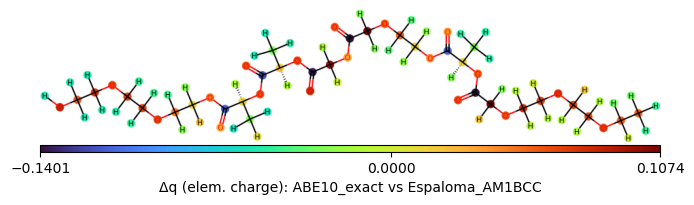

In [6]:
mol_dir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', converter='SMARTS')

## Structure matching and small structure formation for Colina Polymers

In [ ]:
for mol_dir in mgr.mol_dirs_list:
    if mol_dir.solvent == None:
        print(mol_dir.mol_name, mol_dir.n_atoms)

paam_modified 422
pnipam_modified 513
peg_modified 261


INFO:polymer_utils.representation:Loading OpenFF Topology with monomer graph match


{'pdb_atom_id': 1, 'atomic_number': 6, 'atom_name': ' C1 ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 4, 'atomic_number': 6, 'atom_name': ' C2 ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 5, 'atomic_number': 8, 'atom_name': ' O  ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 6, 'atomic_number': 7, 'atom_name': ' N  ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 7, 'atomic_number': 1, 'atom_name': ' H2 ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 8, 'atomic_number': 6, 'atom_name': ' C3 ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 9, 'atomic_number': 1, 'atom_name': ' H3 ', 'residue_name': 'UNL', 'residue_number': 1, 'already_matched': False}
{'pdb_atom_id': 10, 'atomic_number': 6, 'atom_name': ' C4 ', 'residue_name': 'UNL', 'resid

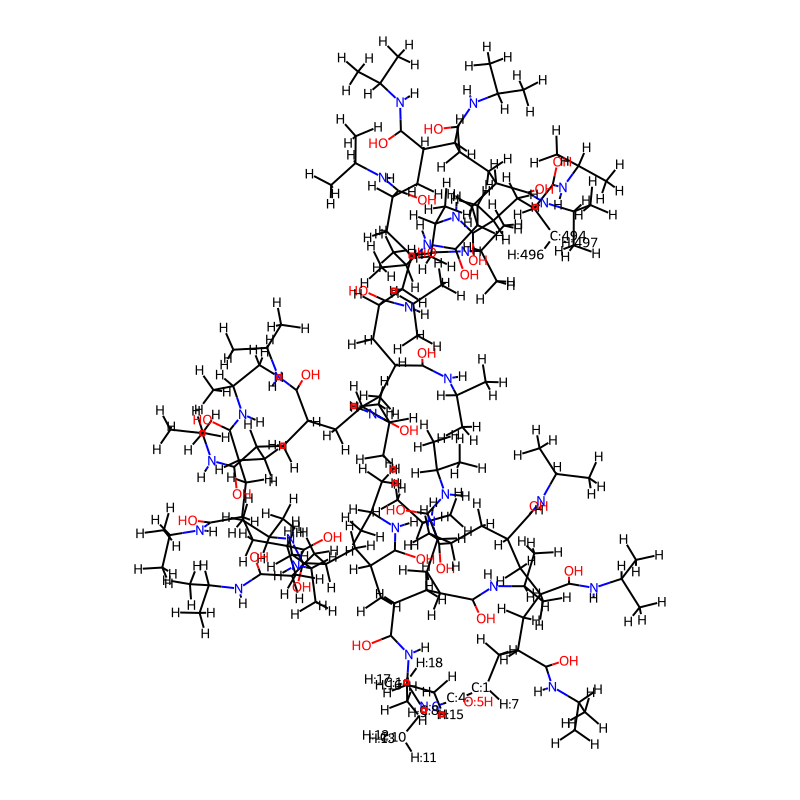

In [ ]:
import copy

pdir = mgr.mol_dirs['pnipam_modified']
# pdir = mgr.mol_dirs['paam_modified']
rdmol = copy.copy(pdir.rdmol)
offmol = pdir.offmol_matched(strict=False)

for atom in offmol.atoms:
    if not atom.metadata['already_matched']:
        num = atom.metadata['pdb_atom_id']
        rdmol.GetAtomWithIdx(num).SetAtomMapNum(num)
        print(atom.metadata)

rdkdraw.set_rdkdraw_size(800, 1/1)
rdmol

pnipam [C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[*:21])-[*:1]


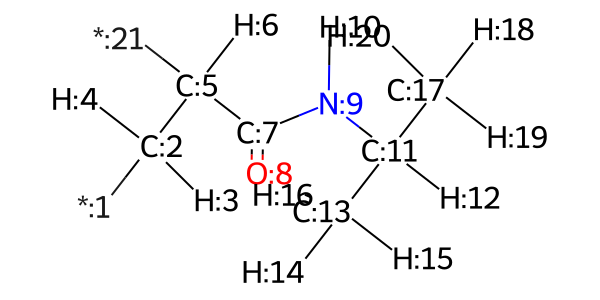

pnipam_TERM2 [C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[#1:21])-[*:1]


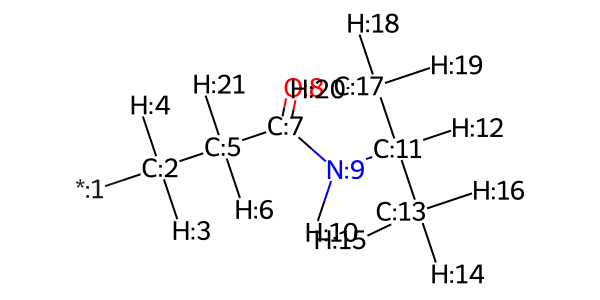

pnipam_TERM3 [C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[*:21])-[#1:1]


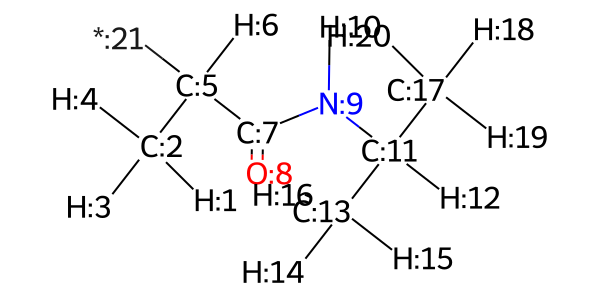

In [ ]:
rdkdraw.set_rdkdraw_size(300, 2/1)
for mono_name, mono_SMARTS in pdir.monomer_data['monomers'].items():
    print(mono_name, mono_SMARTS)
    display(Chem.MolFromSmarts(mono_SMARTS))


In [ ]:
pdir.structure_file, pdir.monomer_file

(PosixPath('Collections/water_soluble_Colina/paam_modified/paam_modified/structures/paam_modified.pdb'),
 PosixPath('Collections/water_soluble_Colina/paam_modified/paam_modified/monomers/paam_modified.json'))

## Testing heatmapping drawing

In [ ]:
cmap = plt.get_cmap('turbo')
# pdir = mgr.mol_dirs['polythiophene_solv_water']
pdir = mgr.mol_dirs['polyethylmethacrylate_solv_water']

dim = 10
aspect = 4/1
annotate = False

for cvtr_type in ('InChI', 'SMARTS', 'CXSMARTS'):
    fig, ax = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap, annotate=annotate, precision=5, converter=cvtr_type)
    fig.set_size_inches(dim, dim * aspect)

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

cvtr = 'InChI'

offmol1 = pdir.charged_offmol_from_sdf('ABE10_exact')
rdmol1 = offmol1.to_rdkit()
flatmol1 = molutils.flattened_rmdol(rdmol1, converter=cvtr)

offmol2 = pdir.charged_offmol_from_sdf('Espaloma_AM1BCC')
rdmol2 = offmol2.to_rdkit()
flatmol2 = molutils.flattened_rmdol(rdmol2, converter=cvtr)

diff = molutils.difference_rdmol(flatmol1, flatmol2, prop='PartialCharge', remove_map_nums=True)
deltas = [diff.GetAtomWithIdx(i).GetDoubleProp('DeltaPartialCharge') for i in range(diff.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(diff, deltas, colorMap='jet', contourLines=10, alpha=0.3)
plt.savefig('test.png')

In [ ]:
# PIL.Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.tostring_argb())

n = 250
img = PIL.Image.frombytes('RGB', (n, n), fig.canvas.tostring_rgb())
display(img)

## Generating heatmaps for all completed simulation in the Manager

In [ ]:
charge_methods = ('ABE10_exact', 'Espaloma_AM1BCC')
outdir = Path('pcharge_heatmaps')/mgr.collection_dir.name
outdir.mkdir(exist_ok=True)
cmaps = [
    'seismic',
    'turbo',
    # 'rainbow',
    # 'terrain',
    # 'BrBG',
    # 'cool',
    # 'spring',
    # 'plasma'
]

for mol_name in mgr.all_completed_sims:
    mol_dir = mgr.mol_dirs[mol_name]
    charged_mols = {
        chg_method : mol_dir.charged_offmol_from_sdf(chg_method).to_rdkit()
            for chg_method in charge_methods
    }
    charged_mols.values()

    for cmap_name in cmaps:
        cmap_dir = outdir/cmap_name
        cmap_dir.mkdir(exist_ok=True)
        cmap = plt.get_cmap(cmap_name)

        fig, ax = rdkdraw.compare_chgd_rdmols(*charged_mols.values(), *charged_mols.keys(), cmap=cmap, flatten=True)
        fig.savefig(cmap_dir/f'{mol_name}.png', bbox_inches='tight')
        plt.close()